In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF
import time

### 1D case

In [2]:
key = random.PRNGKey(int(time.time()))

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.normal(key,x.shape)

In [3]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 1
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (100,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 7
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (length_scale, )

init_kernel = (1.0, )
init_noise = 0.1

In [4]:
model = gpr.SparseGPR(kernel,data_split,referencegrid,init_kernel,noise=init_noise)
model.train(X_data,Y_data)
(means_ppa, stds_ppa) = model.eval(grid.reshape(-1,1),True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

model = gpr.ExactGPR(kernel,data_split,init_kernel,noise=init_noise)
model.train(X_data,Y_data)
(means_full, stds_full) = model.eval(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

OptStep(params=DeviceArray([0.08430655, 1.6687614 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00899694, dtype=float32, weak_type=True), success=True, status=0, iter_num=10))
OptStep(params=DeviceArray([0.083584 , 1.7663982], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.03592612, dtype=float32, weak_type=True), success=True, status=0, iter_num=8))


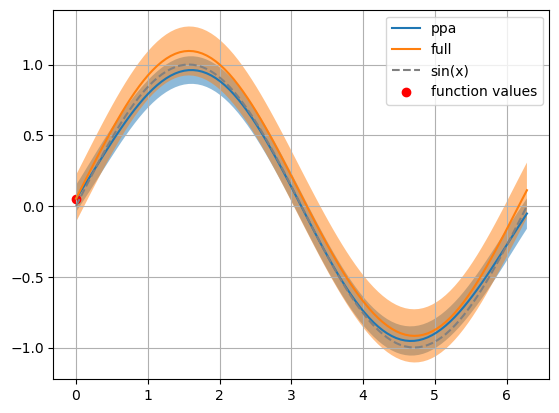

In [5]:
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-2*stds_ppa,means_ppa+2*stds_ppa,alpha=0.5)
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-2*stds_full,means_full+2*stds_full,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

## 2D case

In [6]:
key = random.PRNGKey(0)

def func(x1, x2,noise=0.0):
    return jnp.sin(2*x1 + x2) + noise*random.normal(key, x1.shape)

def dx1_func(x1, x2, noise=0.0):
    return 2*jnp.cos(2*x1 + x2) + noise*random.normal(key, x1.shape)

def dx2_func(x1, x2, noise=0.0):
    return jnp.cos(2*x1 + x2) + noise*random.normal(key, x1.shape)

In [7]:
bounds = jnp.array([[0.0, 2*jnp.pi], [0.0, 2*jnp.pi]])

noise = 0.1

length_scale = 1.0

n_data_points = jnp.array([3, 3])
n_X1_deriv_points = jnp.array([10, 10])
n_X2_deriv_points = jnp.array([10, 10])

n_ref_points = jnp.array([7,7])

n_grid_points = jnp.array([101,101])

kernel = RBF()

kernel_params = (length_scale,)

In [8]:
# all the 1d grids for the according to the n_..._points above
data_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_data_points)]
X1_deriv_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_X1_deriv_points)]
X2_deriv_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_X2_deriv_points)]
ref_grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_ref_points)]

grids = [jnp.linspace(*bounds[i], points) for i,points in enumerate(n_grid_points)]

# all 2d grids
data_grid = jnp.array(jnp.meshgrid(*data_grids)).reshape(2,-1).T
dX1_grid = jnp.array(jnp.meshgrid(*X1_deriv_grids)).reshape(2,-1).T
dX2_grid = jnp.array(jnp.meshgrid(*X2_deriv_grids)).reshape(2,-1).T

#all function values
data_values = func(data_grid[:,0], data_grid[:,1], noise)
dX1_values = dx1_func(dX1_grid[:,0], dX1_grid[:,1], noise)
dX2_values = dx2_func(dX2_grid[:,0], dX2_grid[:,1], noise)

# final data used for prediction
X_data = jnp.concatenate((data_grid, dX1_grid, dX2_grid))
Y_data = jnp.concatenate((data_values, dX1_values, dX2_values))

# reference grid for fitting and predicting
referencegrid = jnp.array(jnp.meshgrid(*ref_grids)).reshape(2,-1).T
# grid on which the means and stds will be predicted
grid = jnp.array(jnp.meshgrid(*grids)).reshape(2,-1).T

# total lengths of the necessary data
total_data_points = jnp.prod(n_data_points)
total_deriv_points = (jnp.prod(n_X1_deriv_points), jnp.prod(n_X2_deriv_points))
total_data_split = (total_data_points, ) + total_deriv_points
total_ref_points = jnp.prod(n_ref_points)
total_grid_points = jnp.prod(n_grid_points)

In [9]:
model = gpr.SparseGPR(kernel, total_data_split, referencegrid, kernel_params, noise=noise)
model.train(X_data, Y_data)
(means_ppa, stds_ppa) = model.eval(grid, True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

model = gpr.ExactGPR(kernel, total_data_split, kernel_params, noise=noise)
model.train(X_data, Y_data)
(means_full, stds_full) = model.eval(grid, True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

OptStep(params=DeviceArray([0.18446884, 1.197409  ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00531708, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))
OptStep(params=DeviceArray([0.08902529, 1.0905982 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.03850139, dtype=float32, weak_type=True), success=True, status=0, iter_num=6))


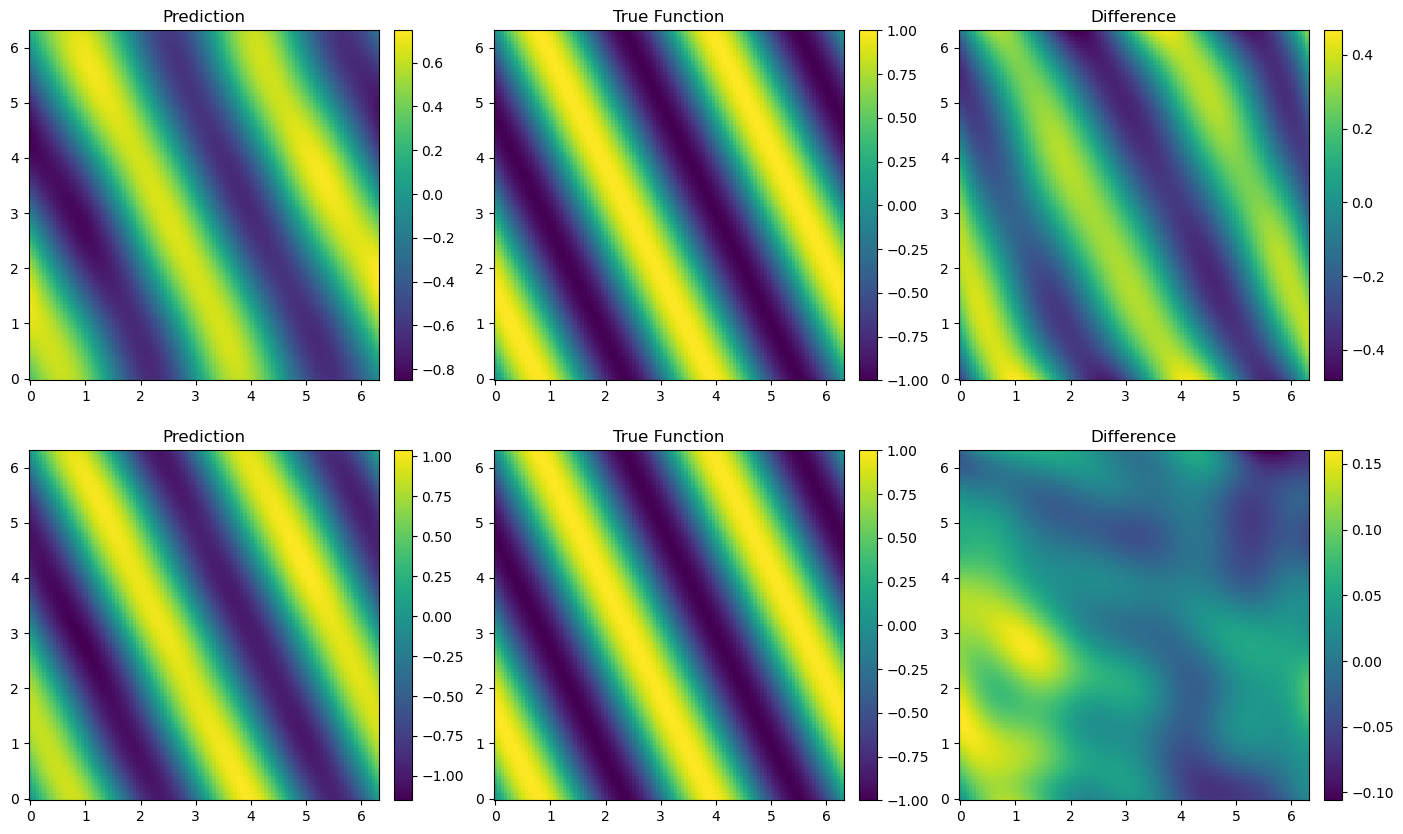

In [10]:
X = jnp.array(jnp.meshgrid(*grids))
Y = func(X[0],X[1])

f, ax = plt.subplots(2,3,figsize=(17,10))

# Approximate GPR
m_plot = ax[0,0].pcolormesh(*grids,means_ppa.reshape(101,101))
ax[0,0].set_aspect('equal', 'box')
ax[0,0].set_title("Prediction")
t_plot = ax[0,1].pcolormesh(*grids,Y)
ax[0,1].set_aspect('equal', 'box')
ax[0,1].set_title("True Function")
diff_plot = ax[0,2].pcolormesh(*grids,Y - means_ppa.reshape(101,101))
ax[0,2].set_aspect('equal', 'box')
ax[0,2].set_title("Difference")
f.colorbar(m_plot, ax=ax[0,0], fraction=0.046, pad=0.04)
f.colorbar(t_plot, ax=ax[0,1], fraction=0.046, pad=0.04)
f.colorbar(diff_plot, ax=ax[0,2], fraction=0.046, pad=0.04)

# Full GPR
m_plot = ax[1,0].pcolormesh(*grids,means_full.reshape(101,101))
ax[1,0].set_aspect('equal', 'box')
ax[1,0].set_title("Prediction")
t_plot = ax[1,1].pcolormesh(*grids,Y)
ax[1,1].set_aspect('equal', 'box')
ax[1,1].set_title("True Function")
diff_plot = ax[1,2].pcolormesh(*grids,Y - means_full.reshape(101,101))
ax[1,2].set_aspect('equal', 'box')
ax[1,2].set_title("Difference")
f.colorbar(m_plot, ax=ax[1,0], fraction=0.046, pad=0.04)
f.colorbar(t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)
f.colorbar(diff_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

In [11]:
def check_along_axis(means, stds, Y, grids):
    means_x1 = jnp.array([means[i,0] for i in range(means.shape[0])])
    means_x2 = jnp.array([means[0,i] for i in range(means.shape[1])])
    stds_x1 = jnp.array([stds[i,0] for i in range(stds.shape[0])])
    stds_x2 = jnp.array([stds[0,i] for i in range(stds.shape[1])])
    Y_x1 = jnp.array([Y[i,0] for i in range(Y.shape[0])])
    Y_x2 = jnp.array([Y[0,i] for i in range(Y.shape[1])])

    f,ax = plt.subplots(1,2)

    ax[0].plot(grids[0],means_x1,label="prediction")
    ax[0].fill_between(grids[0],means_x1-2*stds_x1,means_x1+2*stds_x1,alpha=0.5)
    ax[0].plot(grids[0],Y_x1,label="true")
    
    ax[1].plot(grids[1],means_x2)
    ax[1].fill_between(grids[1],means_x2-2*stds_x2,means_x2+2*stds_x2,alpha=0.5)
    ax[1].plot(grids[1],Y_x2)

    ax[0].grid()
    ax[1].grid()
    f.legend(ncols=2,loc="upper center")

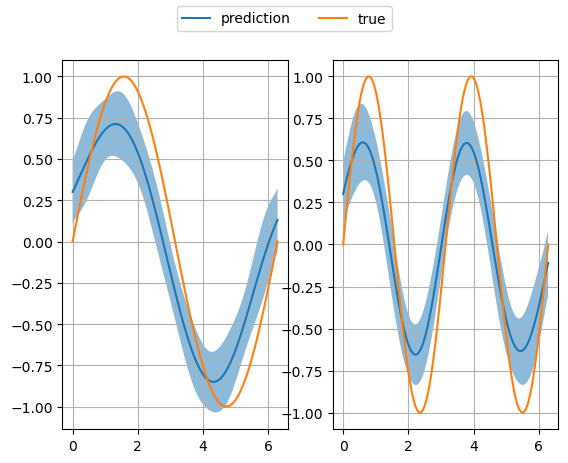

In [12]:
check_along_axis(means_ppa.reshape(101,101),stds_ppa.reshape(101,101),Y,grids)

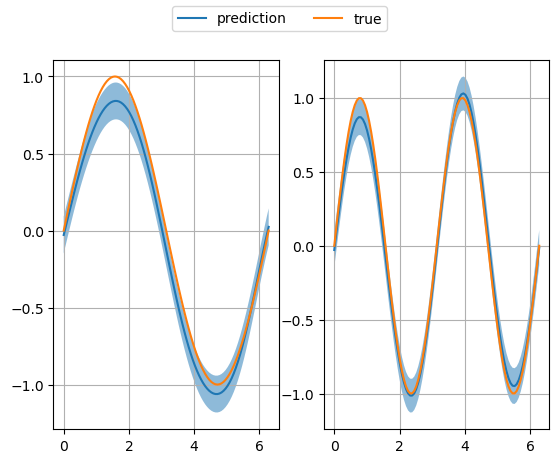

In [13]:
check_along_axis(means_full.reshape(101,101),stds_full.reshape(101,101),Y,grids)